# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import matplotlib 
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore')

# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 18
# pd.set_option('display.max_columns', 100)

In [25]:
data = pd.read_excel('geo_comment.xlsx')

In [3]:
data[['comment_class', 'multiplier']].groupby('comment_class').count()

,multiplier
comment_class,
-1,58552
1,11830


### Для начала посмотрим как выглядят карта голосования по всем голосам.

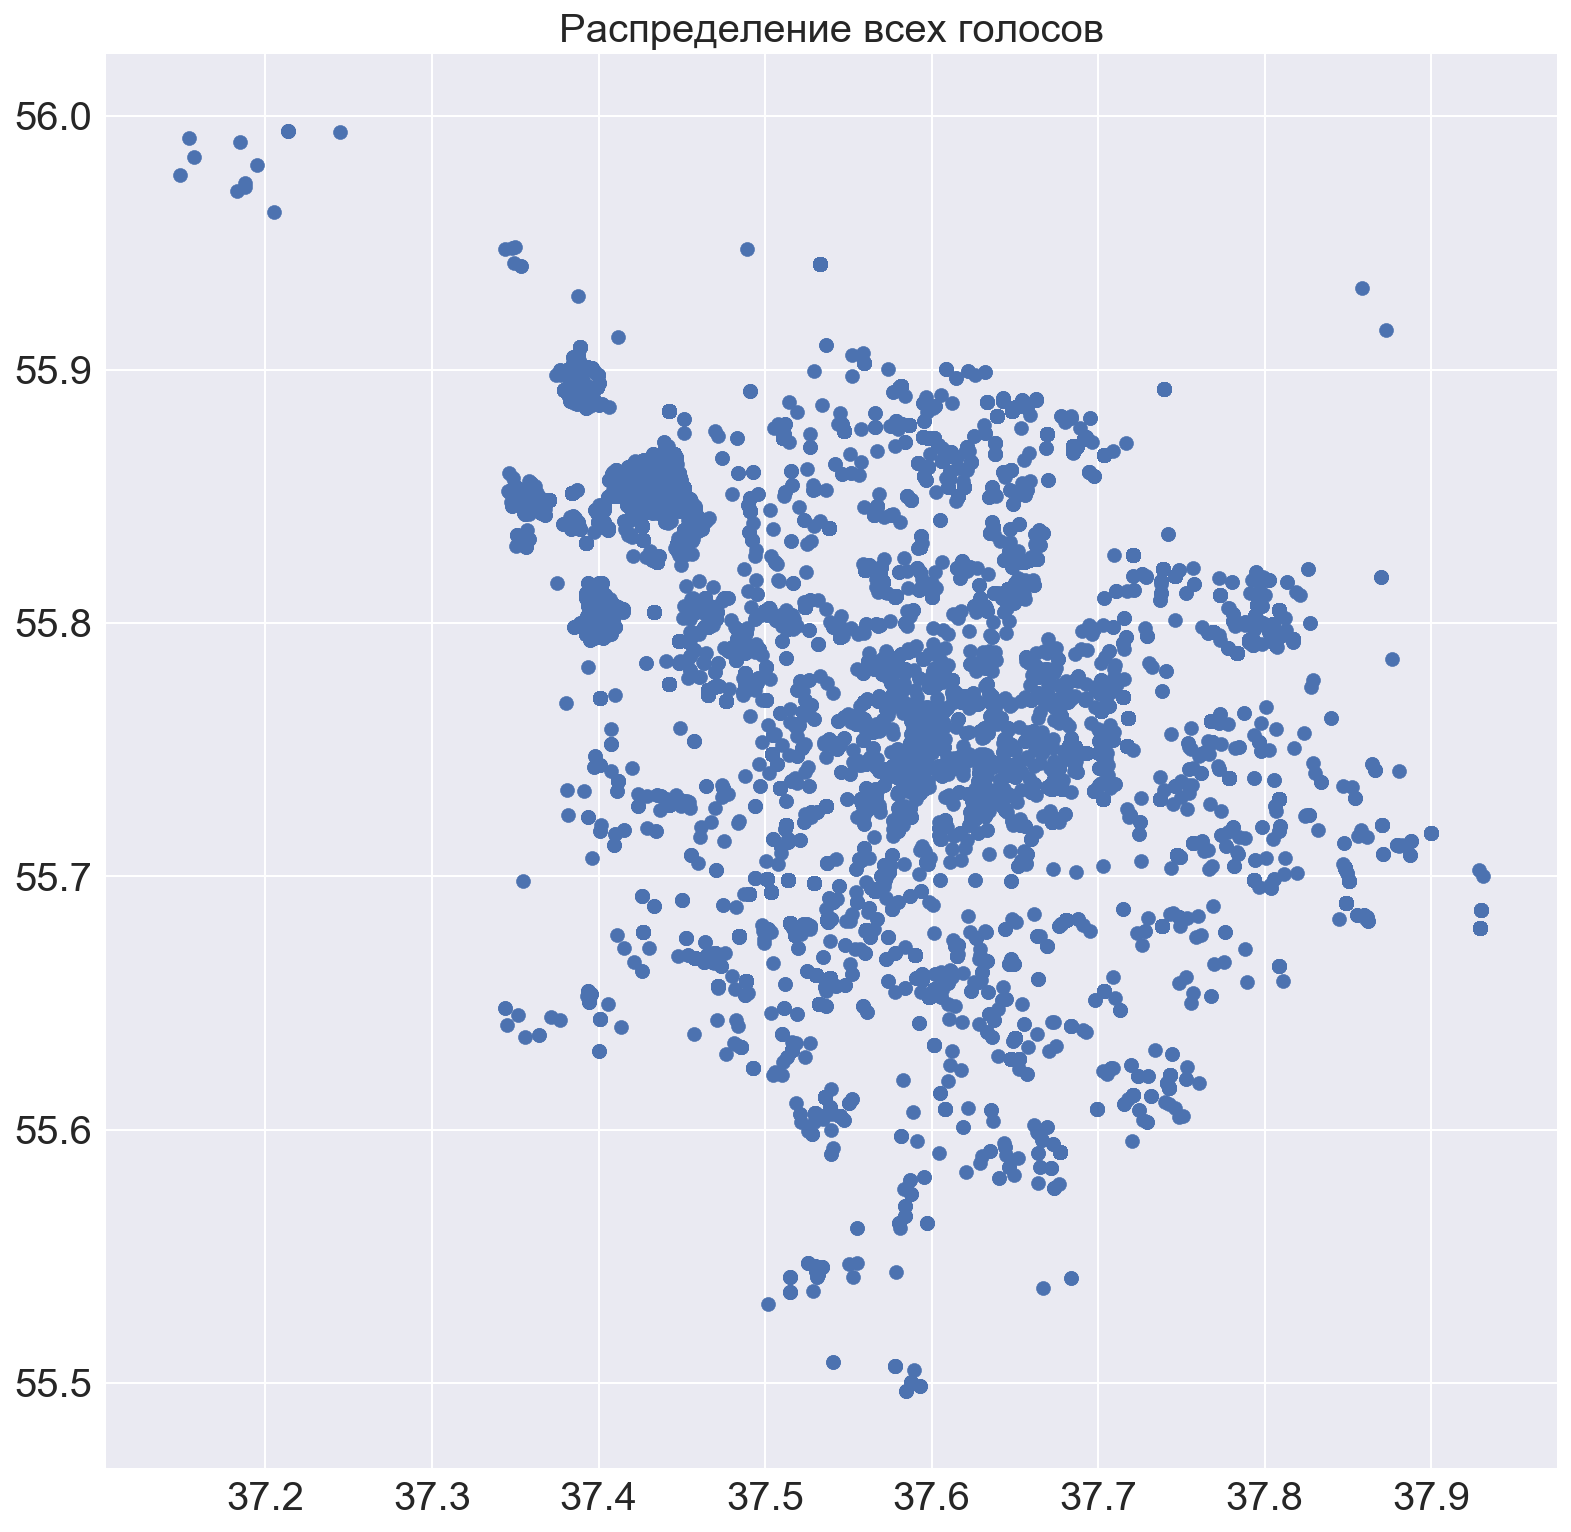

In [4]:
plt.figure(figsize=(13, 13))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.title('Распределение всех голосов', fontsize=20)
plt.scatter(data['x'], data['y'])

### Видно, что это действительно хорошо напоминаем образ Москвы.

In [5]:
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans

### Теперь произведем кластеризацию с помошью KMeans на 10 кластеров. (Число 10 выбрано не случайно: Москва имеет 10 администаривных округов + 2 в Новой Москве, которые тут практически не представлены)  

In [26]:
X = data[['x', 'y']]

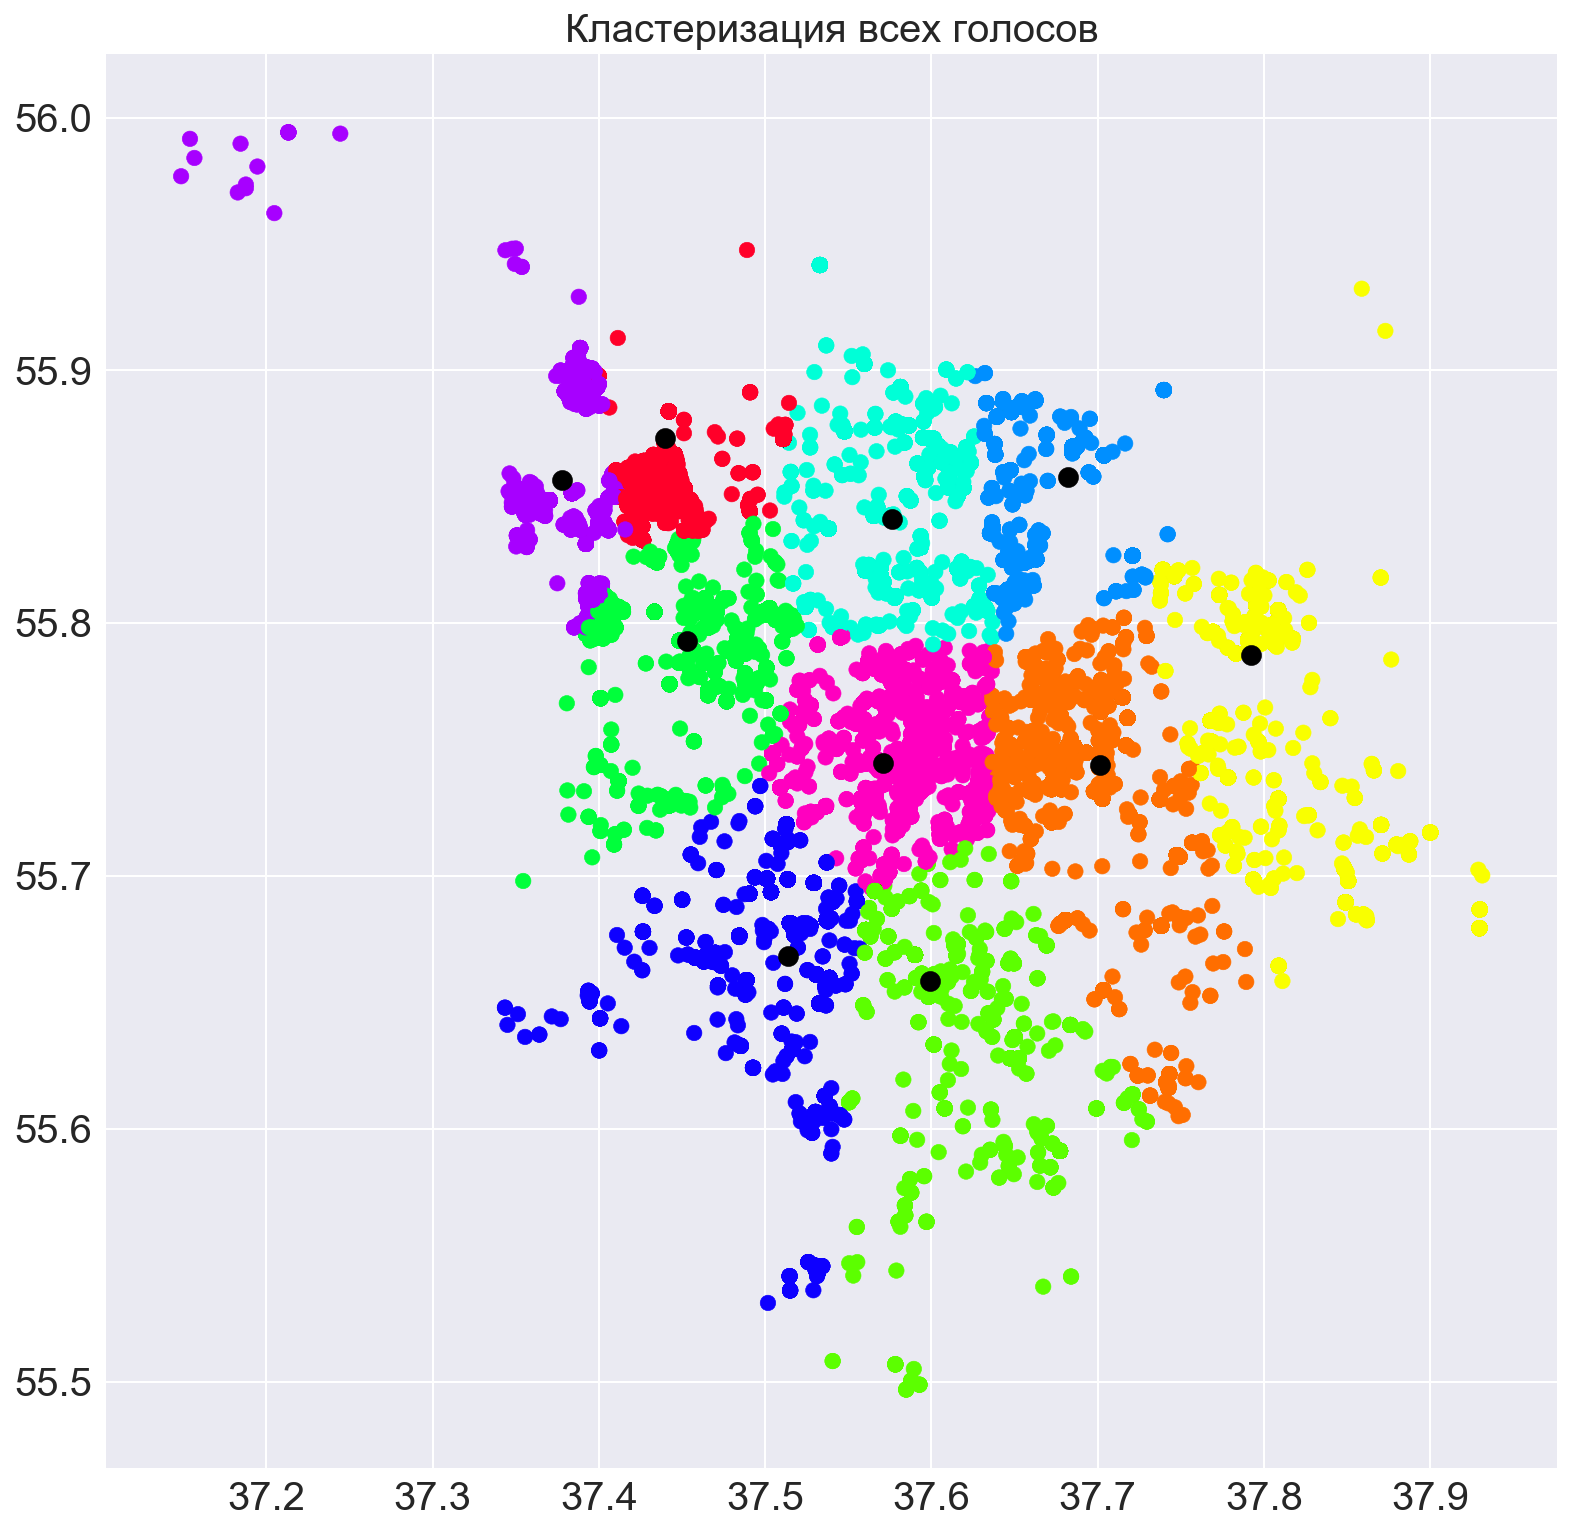

In [28]:
model_KM = MiniBatchKMeans(n_clusters=10)

cluster_KM_x = model_KM.fit_predict(X)

centers_KM_x = model_KM.cluster_centers_

plt.figure(figsize=(13,13))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

plt.title('Кластеризация всех голосов', fontsize=20)
plt.scatter(data['x'], data['y'], c=cluster_KM_x, cmap='gist_rainbow', s=60)
plt.scatter(centers_KM_x[:, 0], centers_KM_x[:, 1], s=100, color='black')

### Видно, что это напоминает реальное адм. деление Москвы, но в северо-западной части есть небольшое отклонение (Зеленоград не отдельный кластер у нас), зато хорошо выражен центр Москвы.

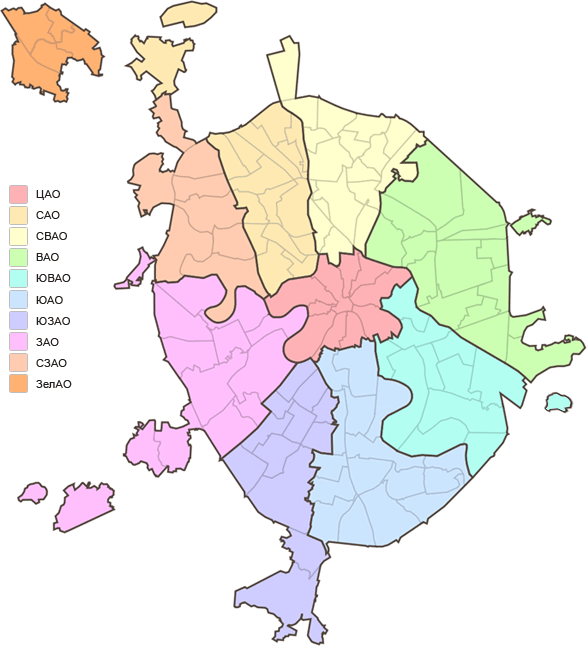

### Теперь отдельно посмотрим кластеризацию для голосов "за" и голосов "против". В наших данных голосов "за" значительно меньше (около 10000) в противовес голосам "против" (около 60000).

In [29]:
X_for = data[data['comment_class']==1][['x', 'y']]
X_against = data[data['comment_class']==-1][['x', 'y']]

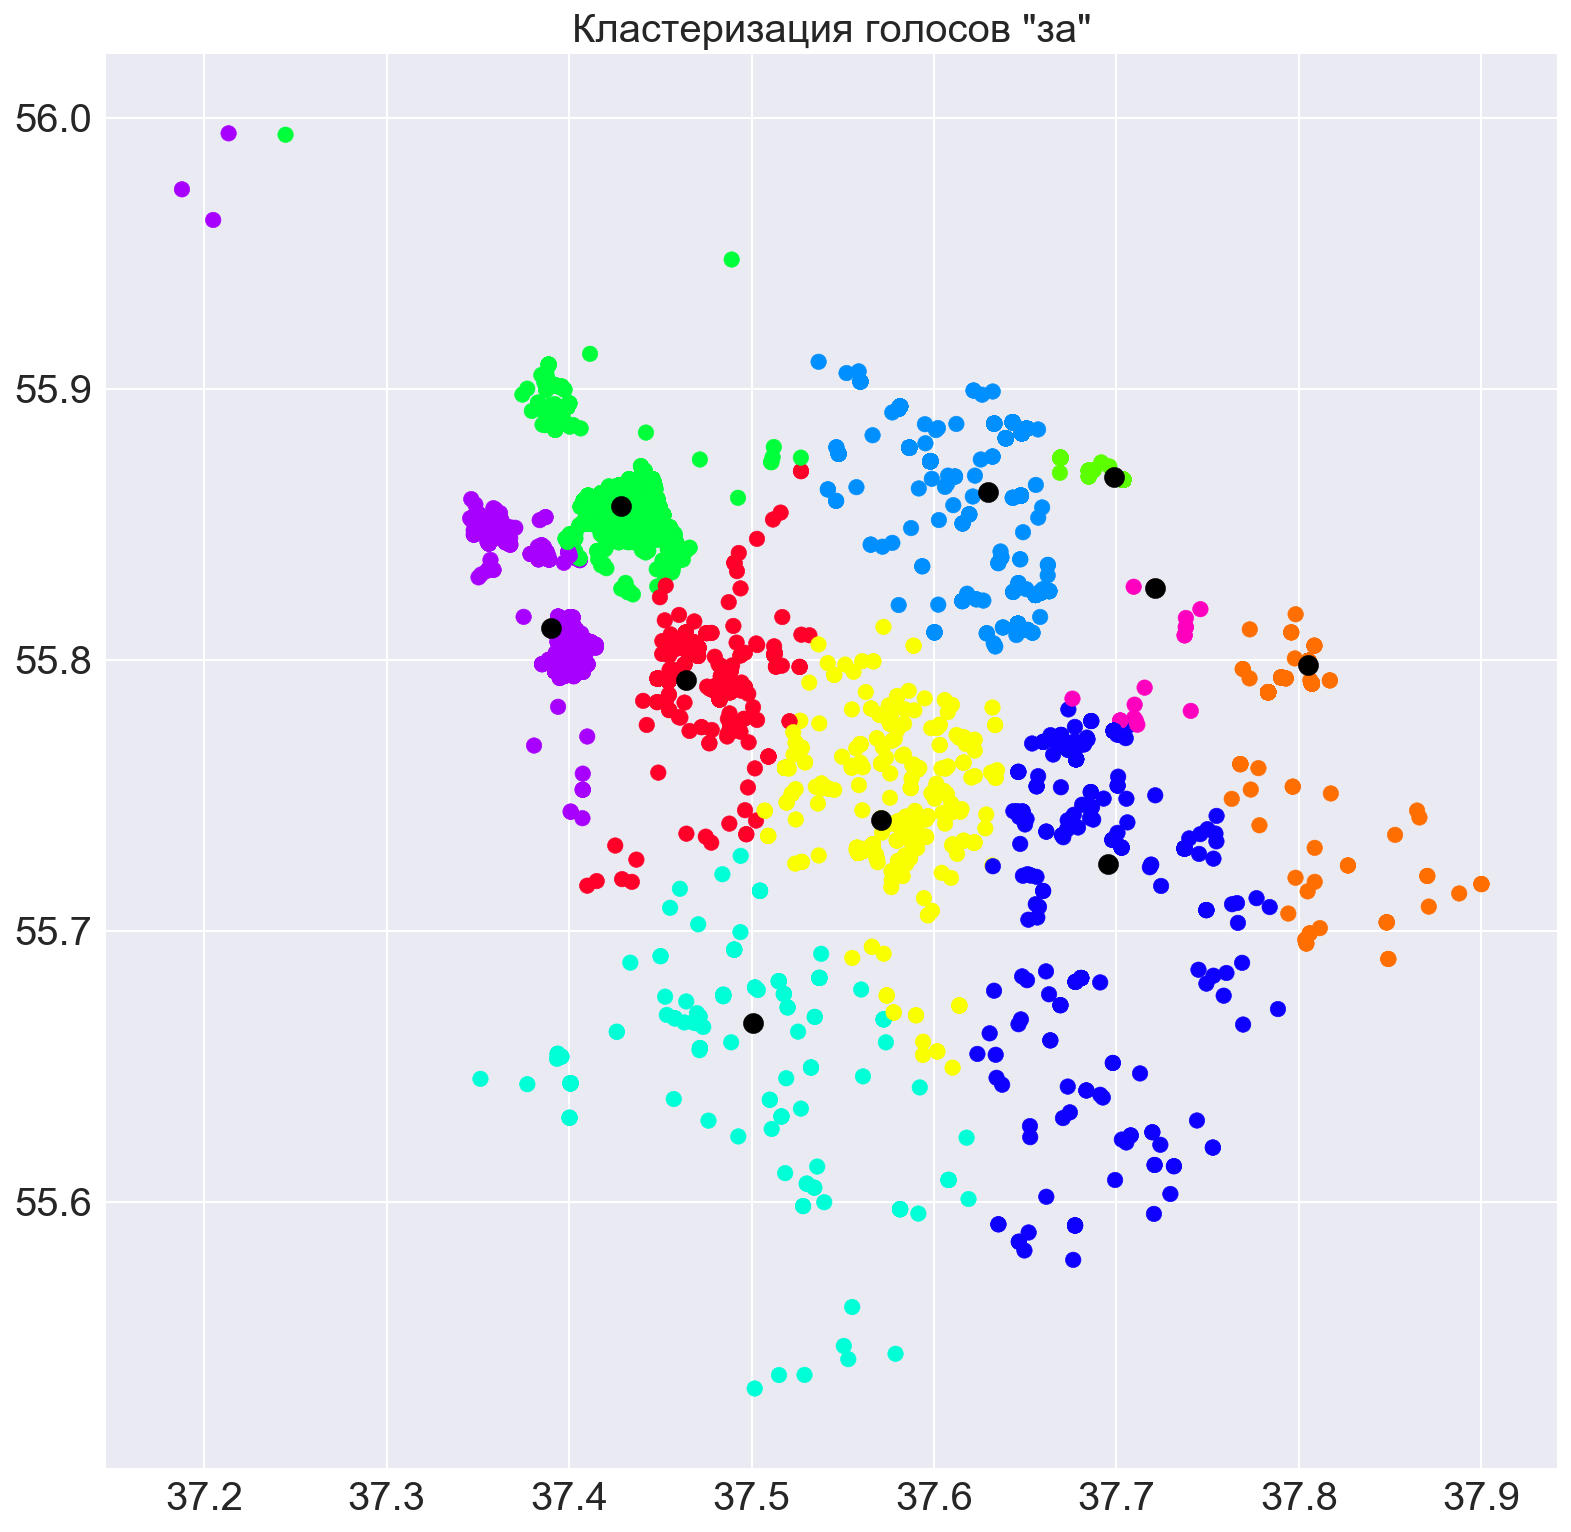

In [30]:
model_KM = MiniBatchKMeans(n_clusters=10)

cluster_KM_f = model_KM.fit_predict(X_for)

plt.figure(figsize=(13,13))
centers_KM_f = model_KM.cluster_centers_

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

plt.title('Кластеризация голосов "за"', fontsize=20)
plt.scatter(X_for['x'], X_for['y'], c=cluster_KM_f, cmap='gist_rainbow', s=60)
plt.scatter(centers_KM_f[:, 0], centers_KM_f[:, 1], s=100, color='black')

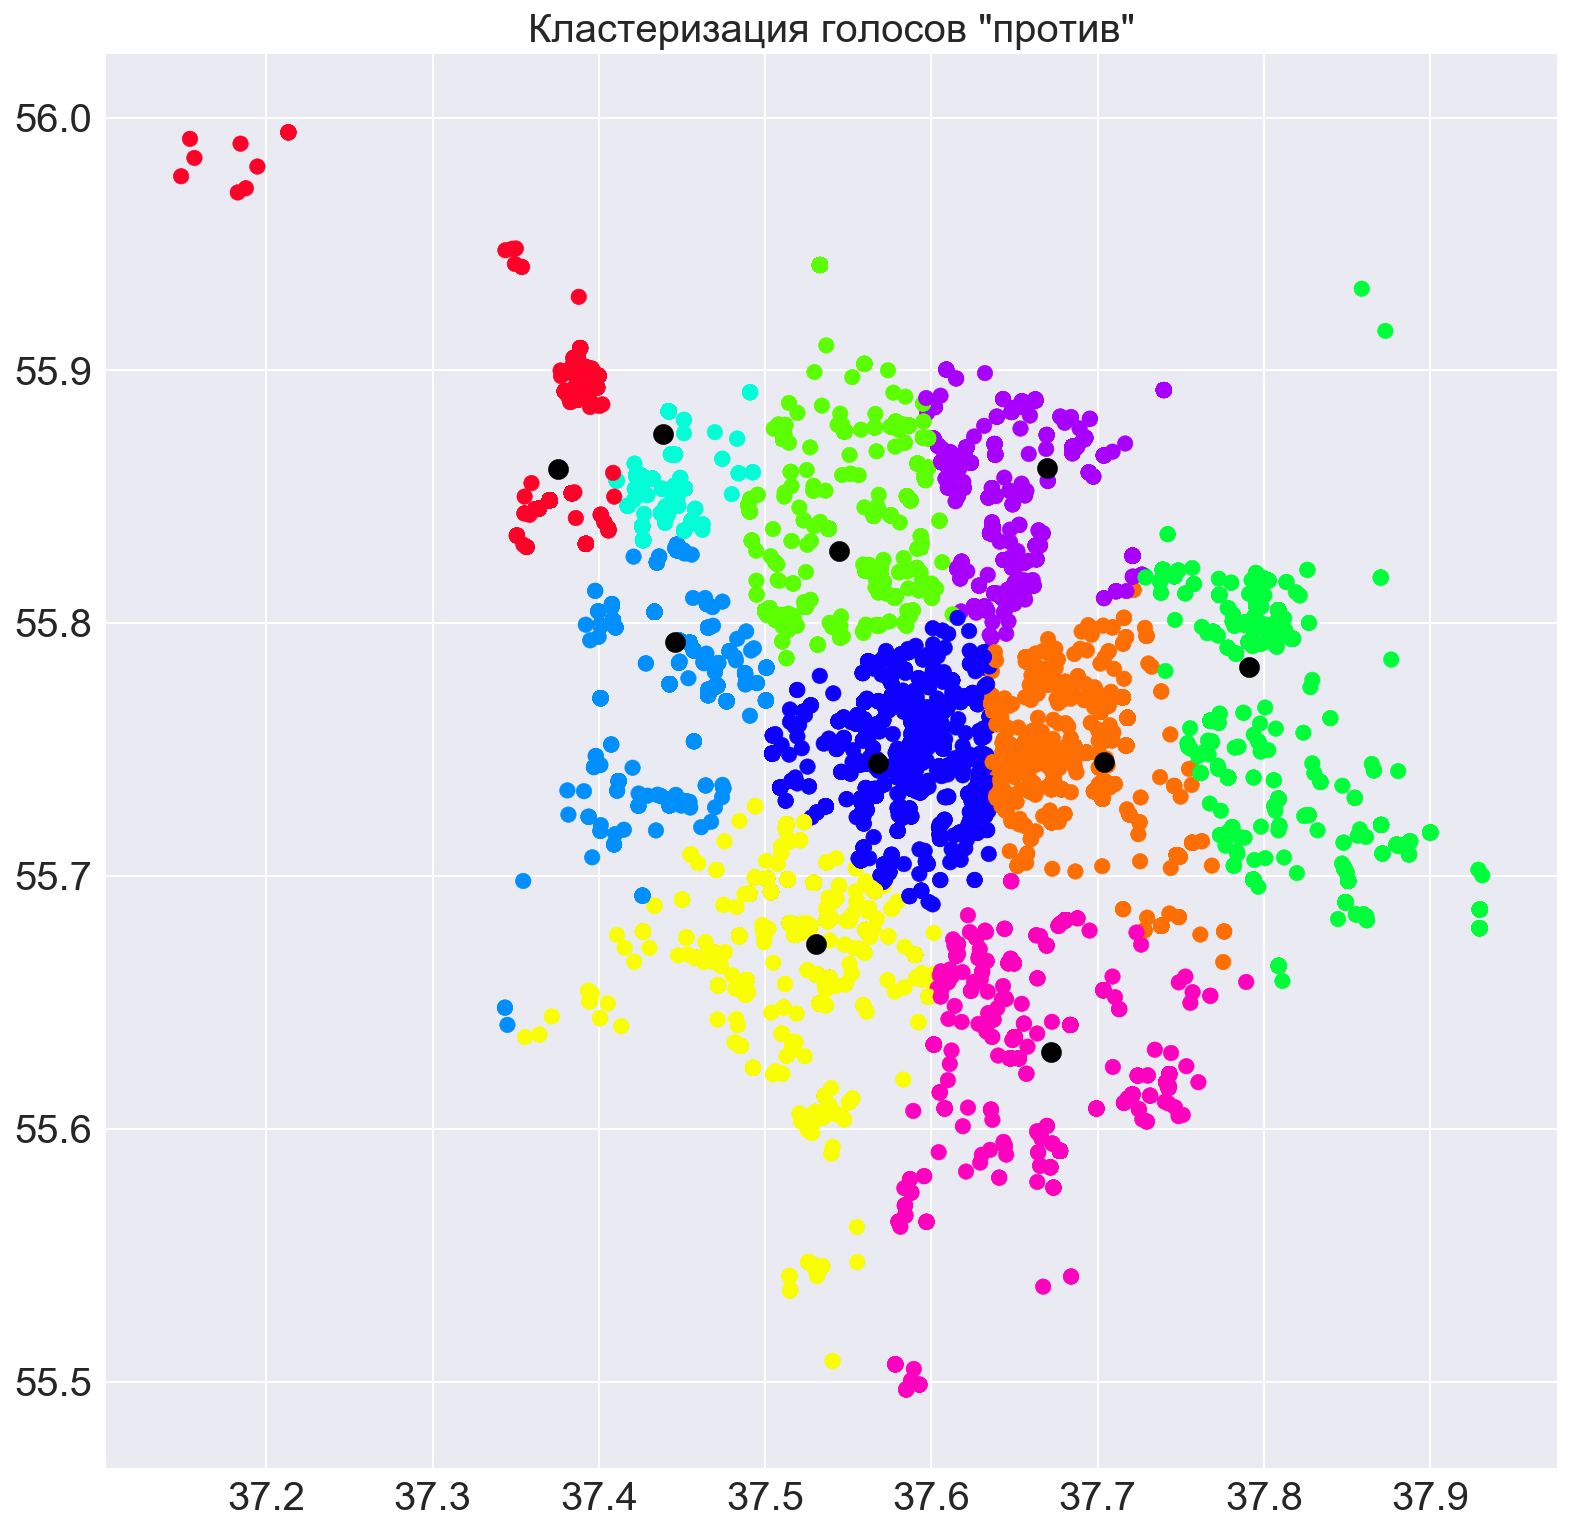

In [32]:
model_KM = MiniBatchKMeans(n_clusters=10)

cluster_KM_a = model_KM.fit_predict(X_against)

plt.figure(figsize=(13,13))
centers_KM_a = model_KM.cluster_centers_

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

plt.title('Кластеризация голосов "против"', fontsize=20)
plt.scatter(X_against['x'], X_against['y'], c=cluster_KM_a, cmap='gist_rainbow', s=60)
plt.scatter(centers_KM_a[:, 0], centers_KM_a[:, 1], s=100, color='black')

### Для сравнения изобразим их на subplot().

Text(0.5, 1.0, 'Кластеризация (все голоса)')

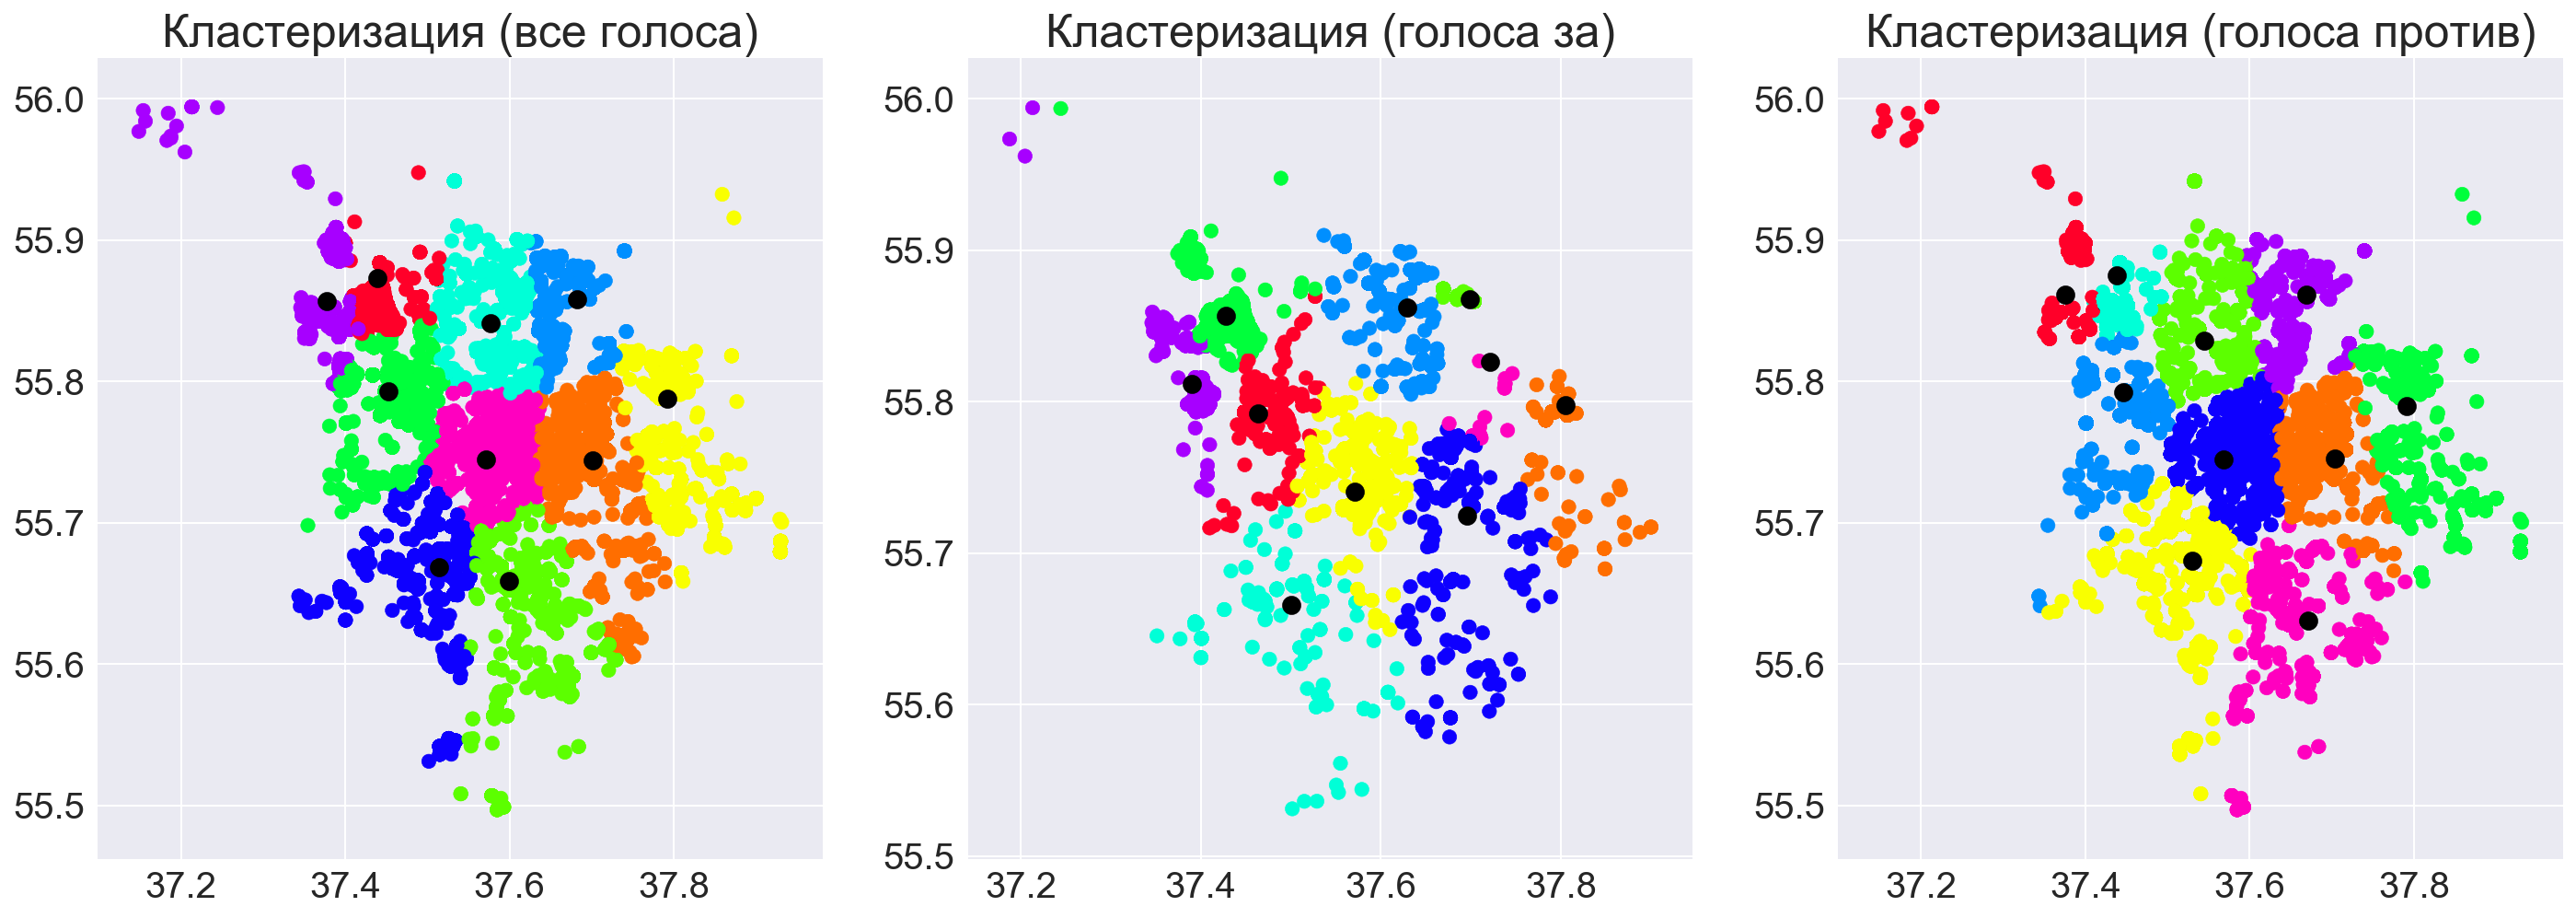

In [33]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

axes[2].scatter(X_against['x'], X_against['y'], c=cluster_KM_a, cmap='gist_rainbow', s=60)
axes[2].scatter(centers_KM_a[:, 0], centers_KM_a[:, 1], s=100, color='black')
axes[2].set_title('Кластеризация (голоса против)', fontsize=25)

axes[1].scatter(X_for['x'], X_for['y'], c=cluster_KM_f, cmap='gist_rainbow', s=60)
axes[1].scatter(centers_KM_f[:, 0], centers_KM_f[:, 1], s=100, color='black')
axes[1].set_title('Кластеризация (голоса за)', fontsize=25)

axes[0].scatter(data['x'], data['y'], c=cluster_KM_x, cmap='gist_rainbow', s=60)
axes[0].scatter(centers_KM_x[:, 0], centers_KM_x[:, 1], s=100, color='black')
axes[0].set_title('Кластеризация (все голоса)', fontsize=25)

### Можно видеть, что кластеризации в целом похожи: всегда есть центр и районы сателиты примыкающие к центру.

### Теперь найдем оптимальную кластеризацию и изобразим с помощью subplot().

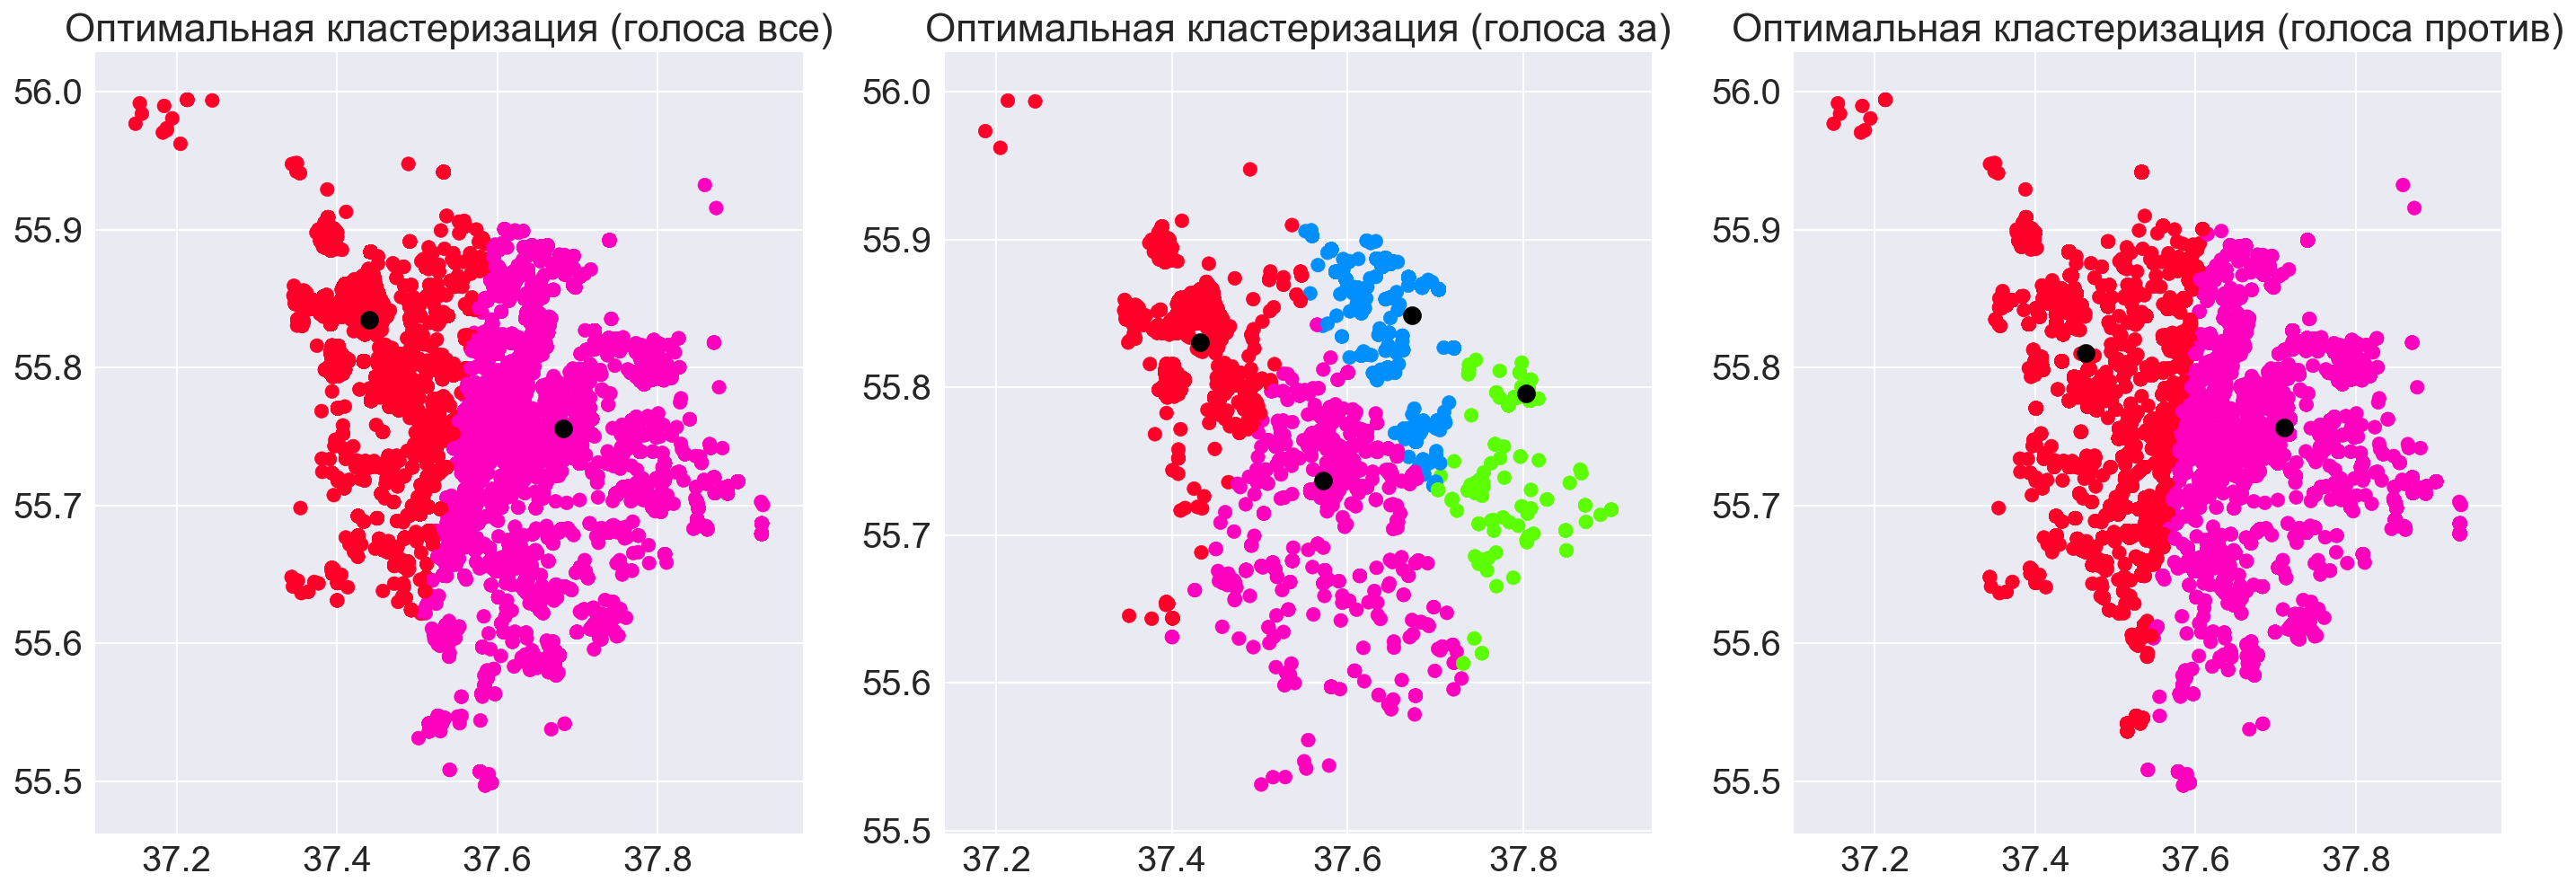

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [12]:
ks = range(1,11)
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
i = 0
how = ['все', 'за', 'против']
for data in [X, X_for, X_against]:
    k_inertia = []
    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(data, )
        k_inertia.append(clf_kmeans.inertia_)
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    k_opt = ks[np.argmin(diff_r)+1]

    model_KM = MiniBatchKMeans(n_clusters=k_opt)

    cluster_KM = model_KM.fit_predict(data)

    plt.figure(figsize=(8,8))
    centers_KM = model_KM.cluster_centers_

    axes[i].scatter(data['x'], data['y'], c=cluster_KM, cmap='gist_rainbow', s=60)
    axes[i].scatter(centers_KM[:, 0], centers_KM[:, 1], s=100, color='black')
    axes[i].set_title('Оптимальная кластеризация (голоса {})'.format(how[i]), fontsize=22)
    i += 1

### Видим, что для большого количества голосов (все и "против") оптимальной является двухкластерная кластеризация, а за меньшего кол-ва голосов (голоса "за") - 4 кластера. 
### Для нас это не самая подходящая кластеризация, так как мы знаем, что работаем с Москвой и она имеет бОльшее кол-во адм. районов. 

### Найдем районы с большой плотностью.

In [13]:
clustering = DBSCAN(eps=0.01, min_samples=500, n_jobs=-1).fit(X)

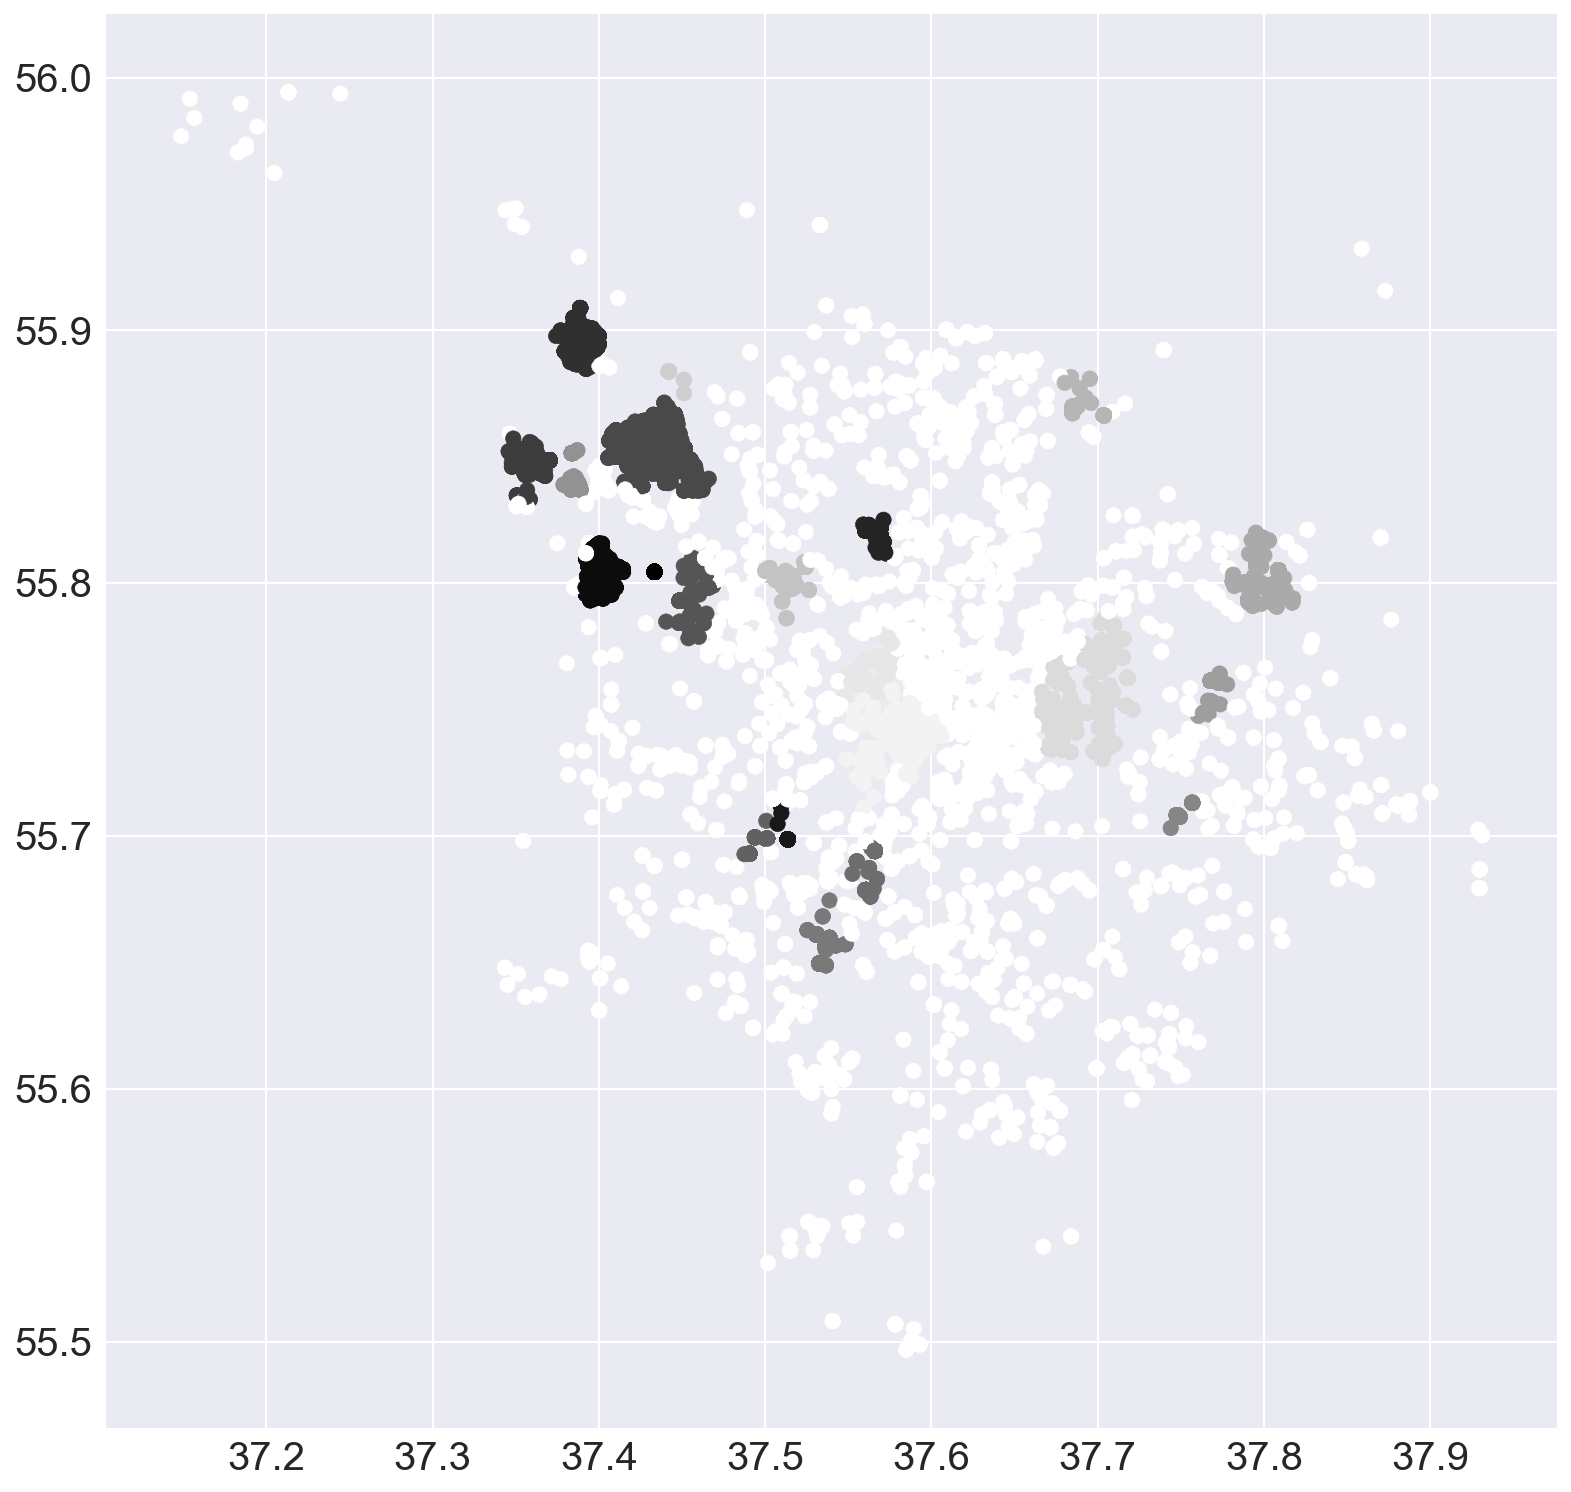

In [14]:
plt.figure(figsize=(13,13))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.scatter(X['x'], X['y'], c=clustering.labels_, cmap='binary', s=60)

### Таким образом, самые плотные районы это северо-запад и некоторые районы востока и центр.

### Теперь составим некоторый набор остовных тем/слов - топиков - в комментариях голосующих. Выделим 25 топиков с помощью LDA модели.

In [15]:
data = pd.read_excel('geo_comment.xlsx')

### Уберем все числа.

In [16]:
data["comment"] = data.comment.apply(lambda x: ' '.join([w if w.isalpha() else '' for w in x.split() if w.isalpha() or w.isdigit()]))

### И очистим от лишнего с помощью stopwords.

In [17]:
from nltk.corpus import stopwords

stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать', u'в', u'a', u'и']
)


comment_dict = {}
i = 0
for comment in data['comment']:
    comment_list = comment.split()
    for word in comment_list:
        if word in stopw:
            comment_list.remove(word)
    comment_dict[i] = comment_list
    i += 1

### Обучим модель.

In [18]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=comment_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=25, passes=12, 
)

### Посмотрим на полученные топики.

In [19]:
print('LdaModel performance')
topic_description = {}
for i in range(25):
    terms = justlda.get_topic_terms(i)
    topic_description[i] = ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms))
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 проекта А ГПЗУ Генеральному придомовой слушаний гаража Протокол публичных ПЗЗ
1 города Москвы публичные слушания застройки функциональной землепользования зоны согласно плану
2 являюсь вместо озелененной Я прилегающей поддерживаю вл Установить существующего Не
3 исключением объектов книги указанные июля проездом своих сооружений виды Размещение
4 жилого парка непосредственной близости благоустройство не территории плотность отменить квартале
5 требуем данном вред менее дополнительного этой ФЗ не основном нарушением
6 Землепользования Застройки дома адресу нормам виды должно Публичные городских подземных
7 земельных кодекса разрешенного Градостроительного города ПЗЗ соответствии РФ территориальных Российской
8 участка соответствии земельного участке согласно земельный земельном благоустройства районе предусмотрено
9 застройки Московской центра площадью построить высотой м общей имеющейся территории
10 станции является жителей проведения слушания домов Земельный ПЗ

In [20]:
dummy_dict = {key: 0 for key in range(25)}

comment_topics_dict_25 = {
    id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(comment)))
    for id, comment in comment_dict.items()
}
check_pd_25 = pd.DataFrame.from_dict(comment_topics_dict_25, orient='index')
check_pd_25.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.036533,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.273419,0.000000,...,0.022407,0.069821,0.094174,0.045192,0.143632,0.050937,0.000000,0.000000,0.208241,0.000000
1,0.029513,0.0,0.000000,0.024358,0.000000,0.0,0.000000,0.050983,0.224413,0.000000,...,0.024636,0.077146,0.053682,0.023494,0.044927,0.217069,0.000000,0.000000,0.149583,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.128050,0.000000,0.000000,0.144860,0.074268,0.000000,0.000000,0.276899,0.041769
3,0.000000,0.0,0.000000,0.033082,0.000000,0.0,0.000000,0.000000,0.148190,0.418552,...,0.000000,0.023029,0.000000,0.000000,0.000000,0.000000,0.000000,0.173237,0.179829,0.000000
4,0.000000,0.0,0.000000,0.033071,0.000000,0.0,0.000000,0.000000,0.148103,0.418342,...,0.000000,0.023500,0.000000,0.000000,0.000000,0.000000,0.000000,0.173153,0.179758,0.000000
5,0.000000,0.0,0.040498,0.000000,0.043545,0.0,0.000000,0.000000,0.055122,0.535676,...,0.000000,0.035525,0.000000,0.049239,0.000000,0.000000,0.000000,0.000000,0.147131,0.066813
6,0.000000,0.0,0.040510,0.000000,0.038101,0.0,0.000000,0.000000,0.000000,0.540486,...,0.000000,0.034947,0.000000,0.049234,0.000000,0.000000,0.000000,0.049562,0.154608,0.066090
7,0.000000,0.0,0.057403,0.063498,0.000000,0.0,0.000000,0.000000,0.237777,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073182,0.065095,0.000000,0.000000
8,0.098263,0.0,0.000000,0.000000,0.000000,0.0,0.069310,0.000000,0.000000,0.000000,...,0.000000,0.209407,0.000000,0.000000,0.000000,0.141345,0.000000,0.000000,0.000000,0.000000
9,0.069763,0.0,0.000000,0.128103,0.121674,0.0,0.125769,0.000000,0.000000,0.121383,...,0.000000,0.067290,0.000000,0.123447,0.000000,0.065151,0.000000,0.137223,0.000000,0.000000


In [21]:
topic_number = []
topic = []
for i in range(0, len(data)):
    number = max(enumerate(check_pd_25.iloc[i]),key=lambda x: x[1])[0]
    topic_number.append(number)
    topic.append(topic_description[number])
    

In [22]:
data['topic_number'] = topic_number
data['topic'] = topic

### Посмотрим на то, какие топики самые популярные.

In [23]:
print("Distribution by the most relevant topic")
pd.Series.round(check_pd_25.idxmax(axis=1).value_counts() * 1. / len(check_pd_25), 4)

Distribution by the most relevant topic


1     0.1733
18    0.1375
7     0.1288
17    0.1061
11    0.1008
22    0.0854
23    0.0388
10    0.0374
12    0.0369
8     0.0300
15    0.0294
9     0.0194
16    0.0192
14    0.0172
20    0.0094
0     0.0092
2     0.0072
19    0.0064
13    0.0032
6     0.0029
24    0.0005
3     0.0004
4     0.0004
21    0.0003
5     0.0001
dtype: float64

#### Так как данных достаточно много возьмем небольшую выборку (например, 1.5%) из наших данных и изобразим на реальной карте Москвы. Для каждого голоса мы будем выводить его топик и результат голосования.

In [24]:
import folium
data0 = data.sample(frac=0.015)

m = folium.Map(location=[55.764414, 37.647859])
for i in range(0, len(data0)):
    if data0['comment_class'].iloc[i] == -1:
        tooltip = 'ПРОТИВ.' + 'Topic - ' + data0['topic'].iloc[i] 
        folium.Marker([data0['y'].iloc[i], data0['x'].iloc[i]], tooltip=tooltip).add_to(m)
    else:
        tooltip = 'ЗА.' + 'Topic - ' + data0['topic'].iloc[i] 
        folium.Marker([data0['y'].iloc[i], data0['x'].iloc[i]], tooltip=tooltip).add_to(m)
m